## **Tarea Práctica** - Fashion mnist

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

In [ ]:
if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()

#### Carga de imagenes

In [780]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

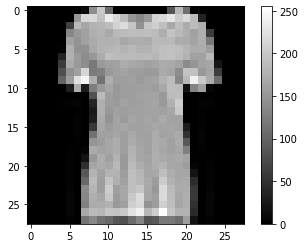

In [519]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

In [520]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

#### Clasificación de imagenes

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

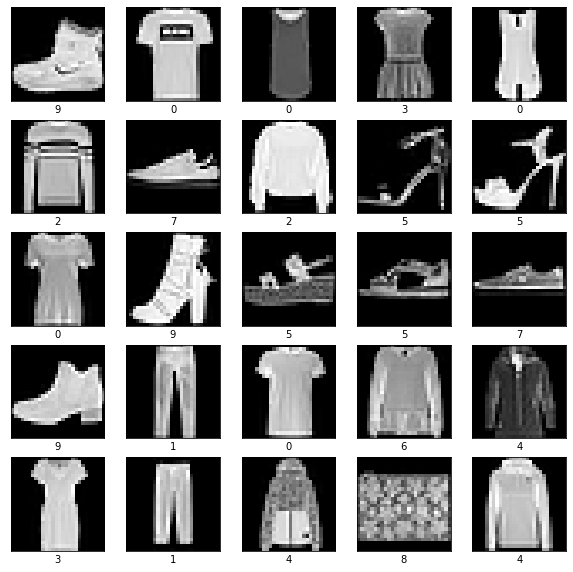

In [521]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

#### Imagenes seleccionadas

| Label | Class       |
|-------|-------------|
| 6     | Shirt       |
| 7     | Sneaker     |
| 9     | Ankle boot  |

#### Filtrado de imagenes

In [781]:
train_images = train_images[(train_labels == 6) | (train_labels == 7) | (train_labels == 9)]
train_labels = train_labels[(train_labels == 6) | (train_labels == 7) | (train_labels == 9)]

test_images = test_images[(test_labels == 6) | (test_labels == 7) | (test_labels == 9)]
test_labels = train_labels[(train_labels == 6) | (train_labels == 7) | (train_labels == 9)]

#### Reshape de datos, diccionario de etiquetas, encoding de imagenes, ...

In [782]:
train_images = train_images.reshape(18000,784)
test_images = test_images.reshape(3000,784)

In [783]:
code_labels = train_labels
dict_labels = {6:"Shirt", 7:"Sneaker", 9:"Ankle boot"}

In [784]:
one_hot = pd.get_dummies(train_labels)
train_labels = one_hot.to_numpy()

In [785]:
labels_encoded = np.unique(np.column_stack([code_labels, train_labels]), axis=0)
keys = labels_encoded[:,0]
values = labels_encoded[:,1:4]
dict_labels_enconded = dict(zip(keys, zip(*values)))

#### Definición del Grafo

In [744]:
tf.reset_default_graph()

weight = tf.Variable(tf.truncated_normal([784, 3]), name = "weight", dtype = tf.float32)
bias = tf.Variable(tf.zeros([1,3]), name = "bias", dtype = tf.float32)

learning_rate = tf.placeholder(shape = [], name = "learning_rate", dtype = tf.float32)
tensor_x = tf.placeholder(shape = [None, 784], name = "tensor_x", dtype = tf.float32)
tensor_y = tf.placeholder(shape = [None, 3], name = "tensor_y", dtype = tf.float32)

with tf.name_scope("logits"):
    logits = tf.matmul(tensor_x, weight) + bias
    
with tf.name_scope("cross_entropy"):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tensor_y))
    cross_entropy_summary = tf.summary.scalar(name="cross_entropy",tensor=cross_entropy)

with tf.name_scope("accuracy"):
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits,1), tf.argmax(tensor_y,1)), tf.float32))
    accuracy_summary = tf.summary.scalar(name="accuracy",tensor=accuracy)

with tf.name_scope("gradient"):
    gradient = tf.gradients(cross_entropy, weight)

with tf.name_scope("new_weight"):
    new_weight = tf.assign(weight, weight - learning_rate * gradient[0])

init = tf.global_variables_initializer()

#### Mini Batch Gradient Descent

In [745]:
batch_size = 32
sample_size = len(train_images)
total_iterations = int(sample_size / batch_size)

def train(epochs, lr):
    with tf.train.MonitoredSession() as session:
        session.run(init)
        writer = tf.summary.FileWriter("./graphs/"+datetime.now().strftime("%Y%m%d_%H%M%S")+"_lr="+str(lr), session.graph)
        for epoch in range(epochs):
            for i in range(total_iterations):
                start_index = i*batch_size
                end_index = start_index+batch_size
                x = np.array(train_images[start_index:end_index])
                y = np.array(train_labels[start_index:end_index])
                
                feed_dict = {tensor_x:x, tensor_y:y, learning_rate:lr}
                entropy_summary = session.run(cross_entropy_summary, feed_dict=feed_dict)
                acc_summary = session.run(accuracy_summary, feed_dict=feed_dict)
                
                _, c, a, w, b = session.run([new_weight, cross_entropy, accuracy, weight, bias],feed_dict=feed_dict)
                if (i % 250 == 0):
                    print("Epoch: {} Iteration: {} Cross Entropy: {} Accuracy: {}".format(epoch,i,c,a))               
                    writer.add_summary(entropy_summary, i)
                    writer.add_summary(acc_summary, i)
        writer.close()
    return (w, b)

#### Definición de la función softmax

In [746]:
def softmax(y):
    e_y = np.exp(y - np.max(y))
    return e_y / e_y.sum()

#### Definición de la función test

In [747]:
def test(weight, bias, image_x):
    label_y = np.matmul(image_x, weight) + bias
    prediction = softmax(label_y)
    
    key_label = [key  for (key, value) in dict_labels_enconded.items() if (value == prediction).all()]
    text_label = [value  for (key, value) in dict_labels.items() if (key == key_label[0])]
    
    plt.imshow(image_x.reshape(28,28), cmap='gray')
    plt.xlabel(text_label[0])
    plt.show()    

#### Grafo del Modelo

<img src="https://raw.githubusercontent.com/estuardozapeta/Statistical-Learning-I-Tarea-5/master/graph.png">

#### Entrenamiento con Epochs = 5 y Learning rate = 0.0012 [Sin normalización]

In [760]:
Weight, Bias = train(5, 0.0012)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch: 0 Iteration: 0 Cross Entropy: 2634.75732421875 Accuracy: 0.625
Epoch: 0 Iteration: 250 Cross Entropy: 227.92324829101562 Accuracy: 0.90625
Epoch: 0 Iteration: 500 Cross Entropy: 78.9892349243164 Accuracy: 0.90625
Epoch: 1 Iteration: 0 Cross Entropy: 47.93365478515625 Accuracy: 0.9375
Epoch: 1 Iteration: 250 Cross Entropy: 246.59146118164062 Accuracy: 0.90625
Epoch: 1 Iteration: 500 Cross Entropy: 99.580322265625 Accuracy: 0.90625
Epoch: 2 Iteration: 0 Cross Entropy: 21.69794464111328 Accuracy: 0.96875
Epoch: 2 Iteration: 250 Cross Entropy: 226.94674682617188 Accuracy: 0.90625
Epoch: 2 Iteration: 500 Cross Entropy: 73.20375061035156 Accuracy: 0.90625
Epoch: 3 Iteration: 0 Cross Entropy: 26.586647033691406 Accuracy: 0.9375
Epoch: 3 Iteration: 250 Cross Entropy: 136.48171997070312 Accuracy: 0.90625
Epoch: 3 Iteration: 500 Cross Entropy: 72.92355346679688 Accuracy:

#### Cross-entropy

<img src="https://raw.githubusercontent.com/estuardozapeta/Statistical-Learning-I-Tarea-5/master/cross_entropy.png">

#### Accuracy

<img src="https://raw.githubusercontent.com/estuardozapeta/Statistical-Learning-I-Tarea-5/master/accuracy.png">

#### Muestra aleatoria de cinco imagenes de prueba

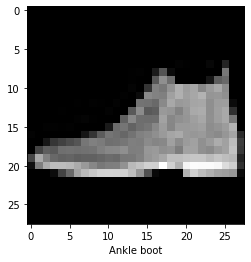

In [794]:
test(Weight, Bias, test_images[0])

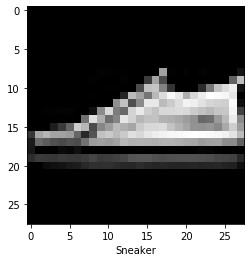

In [793]:
test(Weight, Bias, test_images[55])

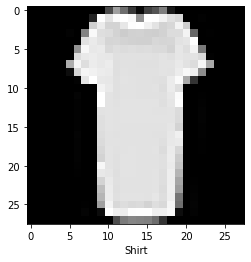

In [567]:
test(Weight, Bias, test_images[200])

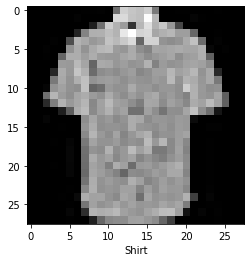

In [795]:
test(Weight, Bias, test_images[500])

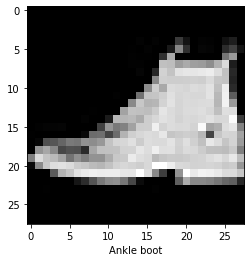

In [796]:
test(Weight, Bias, test_images[2019])

### Normalización

#### Definición de la función para normalizar datos

In [786]:
def normalize_images(images):
    for i in range(len(images)):
        pixels = images[i]
        mean, std = pixels.mean(), pixels.std()
        pixels = (pixels - mean) / std

#### Normalizando datos de entreno

In [787]:
normalize_images(train_images)

#### Entrenamiento con Epochs = 5 y Learning rate = 0.0012 [Datos normalizados]

In [792]:
Weight, Bias = train(5, 0.0012)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch: 0 Iteration: 0 Cross Entropy: 1396.849365234375 Accuracy: 0.3125
Epoch: 0 Iteration: 250 Cross Entropy: 103.84369659423828 Accuracy: 0.90625
Epoch: 0 Iteration: 500 Cross Entropy: 17.256309509277344 Accuracy: 0.96875
Epoch: 1 Iteration: 0 Cross Entropy: 125.28857421875 Accuracy: 0.90625
Epoch: 1 Iteration: 250 Cross Entropy: 57.239070892333984 Accuracy: 0.9375
Epoch: 1 Iteration: 500 Cross Entropy: 2.7801761627197266 Accuracy: 0.96875
Epoch: 2 Iteration: 0 Cross Entropy: 137.09730529785156 Accuracy: 0.90625
Epoch: 2 Iteration: 250 Cross Entropy: 59.12261962890625 Accuracy: 0.9375
Epoch: 2 Iteration: 500 Cross Entropy: 9.60573959350586 Accuracy: 0.96875
Epoch: 3 Iteration: 0 Cross Entropy: 140.34751892089844 Accuracy: 0.90625
Epoch: 3 Iteration: 250 Cross Entropy: 108.72455596923828 Accuracy: 0.875
Epoch: 3 Iteration: 500 Cross Entropy: 0.8030815124511719 Accura

#### Muestra aleatoria de cinco imagenes de prueba

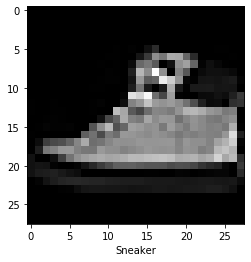

In [797]:
test(Weight, Bias, test_images[18])

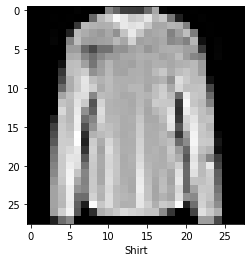

In [799]:
test(Weight, Bias, test_images[607])

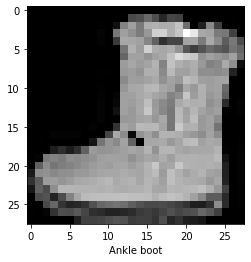

In [800]:
test(Weight, Bias, test_images[1050])

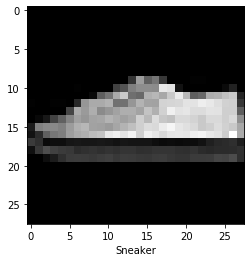

In [801]:
test(Weight, Bias, test_images[2305])

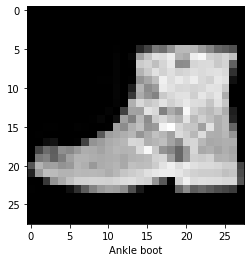

In [802]:
test(Weight, Bias, test_images[2999])

#### Cross-entropy

<img src="https://raw.githubusercontent.com/estuardozapeta/Statistical-Learning-I-Tarea-5/master/cross_entropy_norm.png">

#### Accuracy

<img src="https://raw.githubusercontent.com/estuardozapeta/Statistical-Learning-I-Tarea-5/master/accuracy_norm.png">

### Conclusión

El comportamiento en la función de costo se reduce en menor cantidad de iteraciones con los datos normalizados en comparación de cuando se realiza el entreno con los datos crudos.